## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [24]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [38]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose,MaxPool2D, Flatten, Activation, Dropout,UpSampling2D, GlobalAveragePooling2D, Dense ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

### DenseNet

In [39]:
def Conv_block(x, growth_rate, activation='relu'):
    x_l = BatchNormalization()(x)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate, (3,3), padding='same', kernel_initializer='he_normal')(x_l)
    
    x = concatenate([x, x_l])
    return x

def Dense_block(x, layers, growth_rate=32):
    for i in range(layers):
        x = Conv_block(x, growth_rate)
    return x

def Transition_layer(x, compression_factor=0.5, activation='relu'):
    reduced_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(reduced_filters, (1,1), padding='same', kernel_initializer='he_normal')(x)
    
    x = AveragePooling2D((2,2), padding='same', strides=2)(x)
    return x

def DenseNet(shape=(28,28,3), classes = 10, densenet_type='DenseNet-121'):
    inputs = Input(shape)
    base_growth_rate = 32
    
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
#     x = Transition_layer(x, compression_factor=0.5)
#     x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    x = Activation('relu')(x)
    
    x = MaxPool2D((2,2), strides = 2)(x)
    
    # FC layers
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(rate = 0.5)(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(rate = 0.5)(x)
    
    x = Dense(classes, kernel_initializer='he_normal')(x)
    outputs = layers.Activation('softmax', dtype='float32')(x)
        
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [40]:
layers_in_block = {'DenseNet-121':[6, 12, 24, 16],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

model = DenseNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_882 (Conv2D)             (None, 28, 28, 64)   4864        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_882 (BatchN (None, 28, 28, 64)   256         conv2d_882[0][0]                 
__________________________________________________________________________________________________
activation_883 (Activation)     (None, 28, 28, 64)   0           batch_normalization_882[0][0]    
______________________________________________________________________________________________

In [41]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [42]:
TEST

array([[[[0., 0., 0.],
         [4., 0., 4.],
         [0., 0., 0.],
         ...,
         [2., 0., 2.],
         [4., 0., 4.],
         [1., 0., 1.]],

        [[0., 0., 0.],
         [1., 0., 1.],
         [2., 0., 2.],
         ...,
         [4., 0., 4.],
         [0., 0., 0.],
         [2., 0., 2.]],

        [[1., 0., 1.],
         [2., 0., 2.],
         [4., 0., 4.],
         ...,
         [2., 0., 2.],
         [4., 0., 4.],
         [0., 0., 0.]],

        ...,

        [[1., 0., 1.],
         [0., 0., 0.],
         [1., 0., 1.],
         ...,
         [4., 0., 4.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[4., 0., 4.],
         [3., 0., 3.],
         [2., 0., 2.],
         ...,
         [1., 0., 1.],
         [2., 0., 2.],
         [4., 0., 4.]],

        [[1., 0., 1.],
         [2., 0., 2.],
         [0., 0., 0.],
         ...,
         [4., 0., 4.],
         [1., 0., 1.],
         [4., 0., 4.]]],


       [[[4., 0., 4.],
         [1., 0., 1.],
         [4., 

In [43]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=2, shuffle=True, random_state=SEED)
    
    epochs = 1
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        print(pred_test)
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
32/32 [==============================] - ETA: 0s - loss: 4.2265 - accuracy: 0.0869
Epoch 00001: val_loss improved from inf to 3.64132, saving model to model1_best_0.h5
32/32 [==============================] - 5s 150ms/step - loss: 4.2265 - accuracy: 0.0869 - val_loss: 3.6413 - val_accuracy: 0.0986 - lr: 0.0010


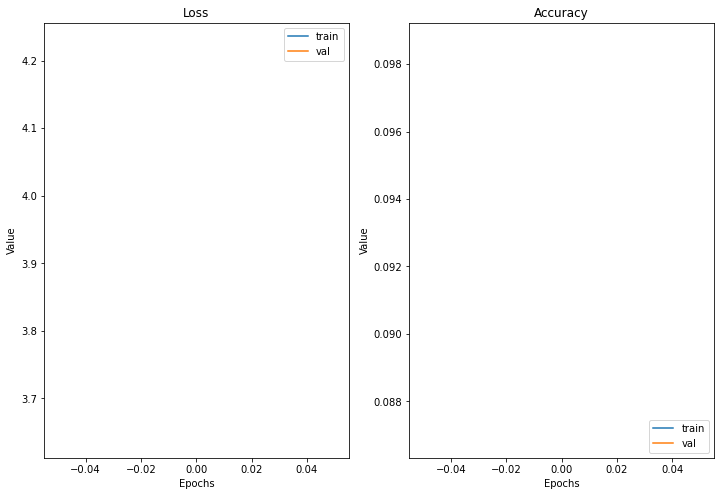

[[9.1541503e-03 1.0018232e-02 7.4595091e-04 ... 8.6715907e-02
  5.5172354e-01 9.2465043e-02]
 [2.8464280e-03 2.7880024e-03 1.7391793e-04 ... 4.3233283e-02
  3.8169906e-02 1.3938969e-01]
 [1.8996965e-02 1.4770974e-02 8.1665540e-04 ... 1.0721590e-01
  5.3568536e-01 8.8449642e-02]
 ...
 [8.6657451e-03 7.4955467e-03 1.0698845e-03 ... 3.3613555e-02
  2.4624357e-01 9.9913985e-02]
 [1.6759552e-02 2.5214661e-02 4.9839192e-03 ... 5.5879366e-02
  1.7061925e-01 1.7589067e-01]
 [3.5926241e-03 2.5602367e-03 2.8958413e-04 ... 5.2801535e-02
  4.9114618e-02 9.8601639e-02]]
*******************number_2_kfold_model*******************
32/32 [==============================] - ETA: 0s - loss: 4.2952 - accuracy: 0.1094
Epoch 00001: val_loss improved from inf to 5.20388, saving model to model1_best_0.h5
32/32 [==============================] - 5s 150ms/step - loss: 4.2952 - accuracy: 0.1094 - val_loss: 5.2039 - val_accuracy: 0.1104 - lr: 0.0010


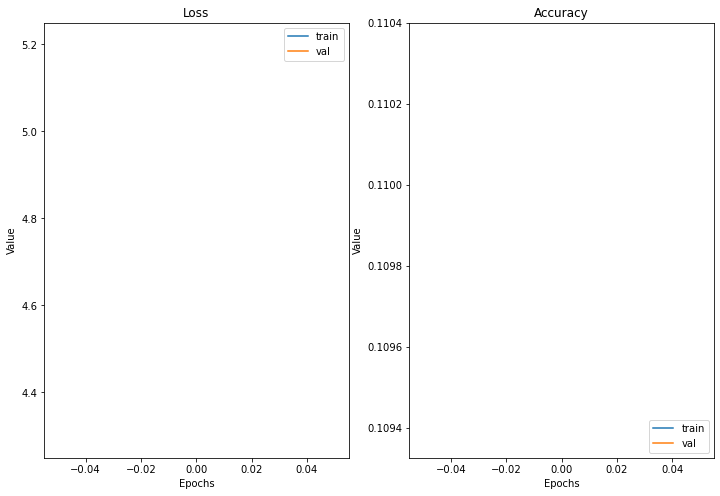

[[2.2245990e-02 4.5379973e-05 6.6403145e-01 ... 6.7036497e-05
  2.2549632e-03 1.8529912e-02]
 [1.9184096e-02 2.0328744e-05 3.7689653e-01 ... 6.2366154e-05
  1.3988594e-03 9.1413520e-02]
 [2.9734433e-02 1.5145514e-04 7.7120310e-01 ... 3.4938936e-04
  4.3883924e-03 1.6363783e-02]
 ...
 [9.6019153e-03 3.2493768e-05 8.9654195e-01 ... 5.8850441e-07
  2.1756422e-03 1.3766405e-02]
 [3.0864706e-02 6.7486608e-04 5.8764076e-01 ... 1.5835764e-04
  2.2671845e-02 6.2833562e-02]
 [6.9464562e-03 1.1276372e-05 5.5157048e-01 ... 1.5009432e-06
  4.0887317e-04 2.5430862e-02]]


In [44]:
DS_train, DS_test = get_stacking(DenseNet, X_trains, y_trains)

In [47]:
DS_test.shape

(20480, 1)

In [52]:
DS_test[70]

array([2])

In [49]:
DS_train

array([[3],
       [2],
       [8],
       ...,
       [2],
       [4],
       [8]])

## Pickle 파일 저장

In [59]:
pickle.dump(DS_train, open("./pickle/DS_train.pkl", "wb"))
pickle.dump(DS_test, open("./pickle/DS_test.pkl", "wb"))